In [1]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
generator = torch.Generator("cuda").manual_seed(31)
# image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", generator=generator).images[0]
# image
pipeline.({"prompt": "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", "generator": generator, "num_inference_steps:":torch.tensor(20)})

SyntaxError: invalid syntax (3749929783.py, line 10)

In [2]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline_text2image = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipeline_text2image = pipeline_text2image.to("cuda")

help(pipeline_text2image)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Help on StableDiffusionXLPipeline in module diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl object:

class StableDiffusionXLPipeline(diffusers.pipelines.pipeline_utils.DiffusionPipeline, diffusers.pipelines.pipeline_utils.StableDiffusionMixin, diffusers.loaders.single_file.FromSingleFileMixin, diffusers.loaders.lora.StableDiffusionXLLoraLoaderMixin, diffusers.loaders.textual_inversion.TextualInversionLoaderMixin, diffusers.loaders.ip_adapter.IPAdapterMixin)
 |  StableDiffusionXLPipeline(vae: diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL, text_encoder: transformers.models.clip.modeling_clip.CLIPTextModel, text_encoder_2: transformers.models.clip.modeling_clip.CLIPTextModelWithProjection, tokenizer: transformers.models.clip.tokenization_clip.CLIPTokenizer, tokenizer_2: transformers.models.clip.tokenization_clip.CLIPTokenizer, unet: diffusers.models.unets.unet_2d_condition.UNet2DConditionModel, scheduler: diffusers.schedulers.scheduling_utils.KarrasDiffus

/home/tak/miniconda3/envs/SDXL/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

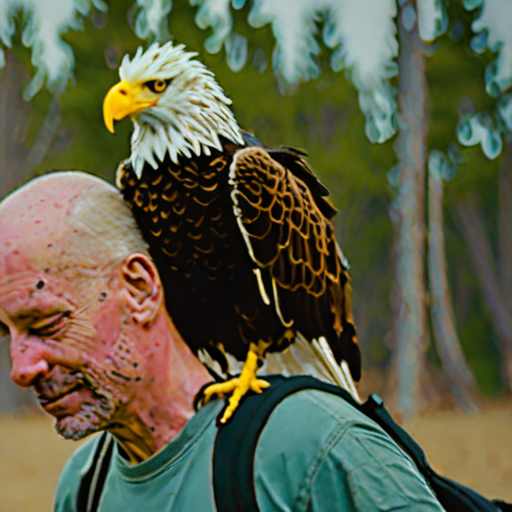

In [1]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline_text2image = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipeline_text2image = pipeline_text2image.to("cuda")

prompt1 = "a close up of a cassette player on a table"
prompt2 = "a man holding a large bald eagle on his shoulder"

image = pipeline_text2image(prompt=prompt1, prompt_2=prompt2 ,guidance_scale=1.5, num_inference_steps=20).images[0]
image

In [ ]:
import torch

In [ ]:
# Model define & Initialize
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from pathlib import Path

from PIL import Image

from typing import Callable, List, Optional, Union, Tuple

from diffusers import StableDiffusionPipeline, AutoPipelineForText2Image

import argparse

from tqdm import tqdm

parser = argparse.ArgumentParser(description="Text to Image Generation with dual caption dataset")

parser.add_argument('--model_num', choices=range(1,5), default="1", help='model name')
parser.add_argument('--root_folder', type=str, default="/data1/ImageNet1K/Annotations/Data/CLS-LOC", help='csv folder path')
parser.add_argument('--class1', type=str, default="n02134084", help='first image class name')
parser.add_argument('--class2', type=str, default="n04552348", help='second image class name')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')

args = parser.parse_args()

model = AutoPipelineForText2Image.from_pretrained(
    f"stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

# ImageCaptionPair Dataset
class ICP_Dataset(Dataset):
    def __init__(self, root_folder: Path, save_image_folder_name: Path):
        self.csv_list = list(root_folder.joinpath('train_csv').glob("*.csv"))
        self.save_image_path = root_folder.joinpath(save_image_folder_name)
        self.save_image_path.mkdir(parents=True, exist_ok=True)

        self.data = pd.concat([pd.read_csv(csv_file, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python') for csv_file in self.csv_list])
        self.image_path = self.data["org_img_path"].tolist()
        self.caption = self.data["caption"].tolist()

        if len(self.image_path) != len(self.caption):
            raise ValueError("image_path and caption must have the same length")

        # self.image_class = list(map(lambda x: x.split("/")[-2], self.image_path))
        # self.image_name = list(map(lambda x: x.split("/")[-1].split(".")[0], self.image_path))

    def __getitem__(self, idx):
        prompt = self.caption[idx]
        generator_seed = idx
        num_inference_steps = 20

        image_path = Path(self.image_path[idx])
        image_cls = image_path.parts[-2]
        image_name = image_path.stem

        return {"prompt": prompt, "generator_seed": generator_seed, "num_inference_steps": num_inference_steps}, self.save_image_path.joinpath(image_cls).joinpath(image_name + ".png")

    def __len__(self):
        return len(self.data)
    

class DualCaptionDataset(ICP_Dataset):
    def __init__(self, root_folder: Path, ensemble_class: List[str], save_image_folder_name: Path = Path("DualCaptionDataset")):
        super().__init__(root_folder, save_image_folder_name)

        # ensemble class define
        if len(ensemble_class) != 2:
            raise ValueError("ensemble_class must be a list of two class")
        else:
            self.ensemble_class = ensemble_class

        # Split the dataframe by classes
        self.data1 = pd.concat([pd.read_csv(csv_file, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python') for csv_file in self.csv_list if csv_file.stem == self.ensemble_class[0]])
        self.data2 = pd.concat([pd.read_csv(csv_file, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python') for csv_file in self.csv_list if csv_file.stem == self.ensemble_class[1]])

        self.image_path1 = self.data1["org_img_path"].tolist()
        self.image_path2 = self.data2["org_img_path"].tolist()

        self.caption1 = self.data1["caption"].tolist()
        self.caption2 = self.data2["caption"].tolist()

        self.length = min(len(self.data1), len(self.data2))  # Use the minimum length of the two dataframes

    def __getitem__(self, idx):
        generator_seed = idx
        num_inference_steps = 20

        # Select one caption from each class
        prompt1 = self.caption1[idx % len(self.caption1)]  # Use modulo to prevent index out of range
        prompt2 = self.caption2[idx % len(self.caption2)]  # Use modulo to prevent index out of range

        image_path1 = Path(self.image_path1[idx % len(self.image_path1)])
        image_cls1 = image_path1.parts[-2]
        image_name1 = image_path1.stem.split("_")[-1]

        image_path2 = Path(self.image_path2[idx % len(self.image_path2)])
        image_cls2 = image_path2.parts[-2]
        image_name2 = image_path2.stem.split("_")[-1]

        prompt = f"mixture of {prompt1} and {prompt2}"
        # image_path, image_cls, image_name = [image_path1, image_path2], [image_cls1, image_cls2], [image_name1, image_name2]

        save_path = self.save_image_path.joinpath(f"{image_cls1}_{image_cls2}/{image_name1}_{image_name2}.png")

        return {"prompt": prompt, "generator_seed": generator_seed, "num_inference_steps": num_inference_steps}, save_path

    def __len__(self):
        return self.length
    

def collate_fn(batch):
    # 데이터 및 메타데이터 리스트 분리
    data_list, meta_list = zip(*batch)

    # 데이터 배치 생성
    data_batch = {
        'prompt': [item['prompt'] for item in data_list],
        'generator_seed': torch.tensor([item['generator_seed'] for item in data_list]),
        'num_inference_steps': torch.tensor([item['num_inference_steps'] for item in data_list]),
    }

    # 메타데이터는 리스트로 유지
    meta_batch = list(meta_list)

    return data_batch, meta_batch

# Dataset & DataLoader
root_folder = Path(args.root_folder)

dataset = DualCaptionDataset(root_folder, ensemble_class=[args.class1, args.class2])
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

# Inference

for batch_idx, (data_batch, path_batch) in enumerate(dataloader):
    generator = [torch.Generator(device="cuda").manual_seed(seed.item()) for seed in data_batch['generator_seed']]
    data_batch["generator"] = generator
    data_batch.pop("generator_seed")
    data_batch["num_inference_steps"] = data_batch["num_inference_steps"][0].item()
    images = model(**data_batch).images
    for img ,path in zip(images, path_batch):
        save_path = Path(path)
        save_folder = save_path.parent
        save_folder.mkdir(parents=True, exist_ok=True)
        img.save(save_path)
    
